# Examples of training the CNN using the images with stratified 5-fold cross validation  using a random 20% from each class

### Uses validation set index 2 (validx1) to produce the confusion matricies in figure 3 of the paper

## requires fastai version 0.7

#### Install instructions here: https://forums.fast.ai/t/fastai-v0-7-install-issues-thread/24652

In [91]:
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from random import sample
from itertools import chain
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, matthews_corrcoef, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, MultiLabelBinarizer

#### set some variables and set your GPU if you have multiple

In [11]:
torch.cuda.set_device(0)   ### use first GPU if you have many
PATH = "data/data_rmsalt_rmol2/pics/" ### path to where your pictures are downloaded and the .csv files with val sets
sz = 224  ### resize images to this px by px
arch = resnext101_64  ### pre-trained network choice
bs = 200   ### batch size for minibatches

## functions


In [178]:

def get_val_cv_byclass(label_csv):
    label_df = pd.read_csv(label_csv)
    val_idxs = []
    for x in label_df['class'].unique(): ### should be class but reversed column labels
        start= label_df.index[label_df['class'] == x].tolist()[0]
        end = start+len(label_df.index[label_df['class'] == x].tolist())-1
        n_sample= int(round((end-start)*0.2,0))
        val_idxs.append(random.sample(range(start,end),n_sample))
    val_idxs = list(chain.from_iterable(val_idxs))
    return val_idxs

def get_val_idx_fromfile(validx_csv):
    validx_df =pd.read_csv(validx_csv, header=None)
    return validx_df[0].tolist()
    
def get_data(sz, bs, val_idxs, label_csv): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv,
                                       val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs, num_workers=2)
    return data if sz > 300 else data.resize(340, 'tmp')



### Function to compute multiclass ROC AUC score from model predictions

In [ ]:
def multiclass_roc_auc_score(y_test, y_probs, AVERAGE="weighted"):
    oh = OneHotEncoder(sparse=False, categories='auto')
    yt = oh.fit_transform(y_test.reshape(-1,1))
    return roc_auc_score(yt, y_probs, average=AVERAGE)

### 3-class, 5-fold cross validation, no data augmentation, precomputed activations

In [224]:
label_csv = f'{PATH}3cls_rmsaltol.csv'

# values to record
vacc =[]
roc = []
mcc = []
bacc = []

reps=5   ### change to 5 for 5-fold cross validation
start=0  #### change to 0 to start at first set for 5-fold cross validation
bs=200
valididx_base = '3cls_val_ids'

for rep in range(reps):
    print(rep+start)
    val_idxs = get_val_idx_fromfile(f'{PATH}'+valididx_base+str(rep+start)+'.csv')
    data = get_data(sz, bs, val_idxs, label_csv)
    learn = ConvLearner.pretrained(arch, data, precompute=True)
    val_loss, val_acc = learn.fit(1e-2, 10, cycle_len=1, cycle_mult=2)
    
    ## record accuracy
    vacc.append(val_acc)
    
    ## get the roc weighted scores
    log_preds, y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    roc.append(multiclass_roc_auc_score(y, probs, "weighted"))
    
    # balanced accuracy
    preds = np.argmax(probs, axis=1)
    bacc.append(balanced_accuracy_score(y, preds))

    # MCC
    mcc.append(matthews_corrcoef(y, preds))
    
print('3 class average, cyclic learning')
print('acc= ' + str(round(np.mean(vacc), ndigits =4)) +' +/- ' + str(round(np.std(vacc),ndigits=4 )))
print('roc score= ' + str(round(np.mean(roc), ndigits =4)) +' +/- ' + str(round(np.std(roc),ndigits=4 )))
print('bal acc= ' + str(round(np.mean(bacc), ndigits =4)) +' +/- ' + str(round(np.std(bacc),ndigits=4 )))
print('mcc= ' + str(round(np.mean(mcc), ndigits =4)) +' +/- ' + str(round(np.std(mcc),ndigits=4 )))


0


epoch      trn_loss   val_loss   accuracy                
    0      1.227245   0.935033   0.567742  
    1      1.087701   0.847505   0.614516                
    2      0.986489   0.814527   0.646774                
    3      0.927407   0.762065   0.693548                 
    4      0.867889   0.735464   0.701613                 
    5      0.817039   0.731541   0.712903                 
    6      0.77946    0.729636   0.71129                  
    7      0.75223    0.714031   0.712903                 
    8      0.727008   0.694869   0.733871                 
    9      0.698585   0.686068   0.733871                 
    10     0.676152   0.667856   0.729032                 
    11     0.653583   0.6686     0.743548                 
    12     0.629208   0.663339   0.748387                
    13     0.609842   0.665896   0.746774                 
    14     0.593994   0.664268   0.751613                 
    15     0.591964   0.662272   0.751613                 
    16     0.578

   138     0.119491   0.723817   0.817742                
   139     0.117319   0.73728    0.809677                 
   140     0.116108   0.75481    0.812903                 
   141     0.118679   0.780916   0.809677                 
   142     0.117581   0.746806   0.817742                 
   143     0.112728   0.763433   0.806452                  
   144     0.109296   0.776593   0.819355                 
   145     0.106605   0.796128   0.803226                 
   146     0.105623   0.747739   0.820968                 
   147     0.105189   0.744607   0.822581                 
   148     0.101374   0.769359   0.816129                 
   149     0.099568   0.772643   0.816129                 
   150     0.095481   0.808349   0.812903                  
   151     0.092628   0.805928   0.803226                  
   152     0.091437   0.74458    0.820968                  
   153     0.090955   0.768123   0.822581                  
   154     0.089835   0.738755   0.817742           

   275     0.051127   0.868033   0.824194                  
   276     0.054706   0.87726    0.819355                  
   277     0.052059   0.883866   0.819355                  
   278     0.052781   0.871162   0.819355                  
   279     0.052764   0.859222   0.820968                  
   280     0.052483   0.884967   0.814516                  
   281     0.055836   0.878999   0.819355                   
   282     0.055714   0.868076   0.822581                  
   283     0.053381   0.84361    0.820968                   
   284     0.051683   0.907863   0.814516                  
   285     0.050119   0.8936     0.822581                  
   286     0.050493   0.873198   0.809677                  
   287     0.050666   0.876647   0.824194                  
   288     0.050416   0.849097   0.825806                  
   289     0.049403   0.874973   0.830645                  
   290     0.048231   0.862609   0.819355                  
   291     0.048896   0.847583   0.812

   411     0.018928   0.973559   0.827419                  
   412     0.018361   0.97789    0.827419                  
   413     0.018996   0.979543   0.820968                  
   414     0.018389   0.984455   0.820968                  
   415     0.019634   0.964038   0.825806                  
   416     0.018694   0.976691   0.820968                  
   417     0.018117   0.988107   0.822581                  
   418     0.018205   0.979038   0.819355                  
   419     0.016971   0.983369   0.824194                  
   420     0.017059   0.988277   0.820968                  
   421     0.015494   0.981502   0.822581                  
   422     0.015363   0.988927   0.820968                  
   423     0.014921   0.98564    0.822581                  
   424     0.016105   0.979926   0.819355                  
   425     0.016311   0.978951   0.819355                  
   426     0.018239   0.989454   0.819355                  
   427     0.017008   0.993749   0.82096

   547     0.026264   0.980571   0.825806                 
   548     0.025669   1.004916   0.820968                  
   549     0.023831   1.049496   0.809677                  
   550     0.023694   0.985756   0.817742                 
   551     0.023993   1.008794   0.81129                   
   552     0.024723   1.026083   0.816129                  
   553     0.023485   1.041796   0.814516                   
   554     0.023457   1.02706    0.814516                  
   555     0.024137   0.979235   0.817742                  
   556     0.025244   0.982562   0.817742                 
   557     0.026377   1.037936   0.812903                  
   558     0.025271   1.00514    0.809677                  
   559     0.02372    1.010436   0.812903                  
   560     0.02318    1.012559   0.812903                  
   561     0.021786   0.995124   0.816129                  
   562     0.022435   0.9893     0.814516                  
   563     0.022341   1.001556   0.81129  

   683     0.010902   1.058872   0.830645                  
   684     0.010834   1.037685   0.833871                 
   685     0.010593   1.039846   0.825806                  
   686     0.010741   1.046173   0.827419                  
   687     0.011958   1.038123   0.835484                  
   688     0.012054   1.049229   0.830645                  
   689     0.012167   1.049788   0.830645                  
   690     0.01144    1.062864   0.825806                  
   691     0.010567   1.062908   0.827419                  
   692     0.010014   1.057517   0.829032                  
   693     0.010718   1.05523    0.824194                  
   694     0.010641   1.057157   0.822581                  
   695     0.010571   1.066391   0.817742                  
   696     0.009887   1.042731   0.825806                  
   697     0.010386   1.034454   0.827419                   
   698     0.011125   1.039009   0.829032                  
   699     0.010474   1.030415   0.83064

   818     0.006326   1.055999   0.829032                   
   819     0.005871   1.059734   0.830645                   
   820     0.006547   1.066334   0.829032                   
   821     0.007859   1.068812   0.832258                   
   822     0.007494   1.058431   0.827419                   
   823     0.008992   1.043975   0.827419                   
   824     0.009854   1.054339   0.830645                   
   825     0.008895   1.047697   0.829032                   
   826     0.008504   1.044695   0.830645                   
   827     0.007832   1.040963   0.835484                   
   828     0.007316   1.042062   0.829032                   
   829     0.006712   1.040167   0.830645                   
   830     0.007128   1.043643   0.835484                   
   831     0.006813   1.034373   0.835484                   
   832     0.007069   1.038579   0.833871                   
   833     0.006772   1.045735   0.829032                   
   834     0.006699   1.

   952     0.004262   1.070326   0.825806                   
   953     0.00463    1.077672   0.825806                   
   954     0.005397   1.073261   0.827419                   
   955     0.005741   1.06929    0.825806                  
   956     0.005282   1.084396   0.827419                   
   957     0.005445   1.07922    0.827419                   
   958     0.005625   1.075953   0.825806                   
   959     0.005373   1.084473   0.824194                   
   960     0.005284   1.073937   0.825806                   
   961     0.005221   1.069885   0.825806                   
   962     0.005398   1.078643   0.829032                   
   963     0.005566   1.072621   0.830645                   
   964     0.005286   1.074321   0.829032                   
   965     0.005972   1.070844   0.825806                  
   966     0.006119   1.06816    0.825806                   
   967     0.006242   1.076964   0.827419                   
   968     0.006454   1.07

epoch      trn_loss   val_loss   accuracy                
    0      1.228754   0.934233   0.574194  
    1      1.081485   0.829685   0.632258                
    2      0.977529   0.785116   0.653226                
    3      0.916024   0.761302   0.669355                 
    4      0.855231   0.725811   0.698387                 
    5      0.811586   0.72055    0.706452                 
    6      0.778394   0.716653   0.708065                 
    7      0.751212   0.706147   0.717742                 
    8      0.72522    0.678307   0.732258                 
    9      0.696942   0.664507   0.725806                 
    10     0.674731   0.662372   0.75                     
    11     0.649287   0.646675   0.745161                 
    12     0.625649   0.646977   0.758065                 
    13     0.605755   0.644761   0.753226                 
    14     0.590346   0.645847   0.754839                 
    15     0.578868   0.641026   0.745161                 
    16     0.56

   138     0.119536   0.687505   0.827419                 
   139     0.117054   0.673185   0.816129                 
   140     0.114389   0.702039   0.817742                 
   141     0.115225   0.710447   0.816129                 
   142     0.116616   0.693691   0.820968                 
   143     0.111153   0.691369   0.814516                 
   144     0.110983   0.713855   0.820968                 
   145     0.109516   0.694139   0.817742                
   146     0.107187   0.719301   0.820968                
   147     0.104938   0.700884   0.812903                 
   148     0.101716   0.705899   0.820968                 
   149     0.101831   0.728724   0.809677                 
   150     0.101849   0.738651   0.8                      
   151     0.102239   0.715706   0.808065                 
   152     0.102694   0.721109   0.808065                 
   153     0.099731   0.754934   0.806452                 
   154     0.096602   0.724188   0.806452                 

   275     0.054939   0.778776   0.819355                  
   276     0.050309   0.81258    0.814516                  
   277     0.050211   0.817439   0.825806                
   278     0.050814   0.798475   0.812903                  
   279     0.051785   0.782434   0.819355                  
   280     0.051385   0.775456   0.827419                  
   281     0.050739   0.812413   0.822581                  
   282     0.049938   0.804548   0.824194                  
   283     0.049616   0.778787   0.829032                  
   284     0.048545   0.783415   0.825806                  
   285     0.049799   0.767584   0.827419                  
   286     0.049555   0.763756   0.824194                  
   287     0.049725   0.802068   0.822581                  
   288     0.050547   0.782703   0.832258                  
   289     0.050377   0.820682   0.820968                  
   290     0.053403   0.807117   0.825806                  
   291     0.052251   0.774244   0.829032 

   411     0.019109   0.876122   0.832258                  
   412     0.017965   0.881251   0.833871                  
   413     0.020188   0.871831   0.830645                  
   414     0.018615   0.886401   0.824194                  
   415     0.017146   0.871304   0.827419                  
   416     0.016692   0.887339   0.830645                  
   417     0.01677    0.882866   0.829032                  
   418     0.016161   0.890171   0.829032                  
   419     0.015843   0.895698   0.827419                  
   420     0.015958   0.903082   0.829032                  
   421     0.016785   0.897604   0.829032                  
   422     0.016524   0.903355   0.827419                  
   423     0.015862   0.896916   0.827419                  
   424     0.015874   0.901847   0.825806                  
   425     0.015901   0.910381   0.829032                  
   426     0.015033   0.905004   0.829032                  
   427     0.014316   0.902022   0.82258

   547     0.020479   0.885744   0.827419                  
   548     0.020009   0.890626   0.829032                  
   549     0.019322   0.902614   0.827419                  
   550     0.018888   0.886964   0.827419                  
   551     0.020875   0.904587   0.819355                  
   552     0.020666   0.890166   0.819355                  
   553     0.020152   0.909053   0.825806                  
   554     0.019674   0.877443   0.827419                
   555     0.022805   0.854149   0.824194                  
   556     0.021468   0.887122   0.830645                  
   557     0.021621   0.890243   0.832258                  
   558     0.021009   0.878308   0.825806                  
   559     0.021694   0.885455   0.822581                  
   560     0.022469   0.912229   0.824194                  
   561     0.021455   0.913172   0.822581                  
   562     0.021919   0.853963   0.832258                  
   563     0.020864   0.867423   0.824194 

   683     0.015158   0.983298   0.814516                  
   684     0.015336   0.960628   0.827419                  
   685     0.014583   0.946379   0.824194                  
   686     0.013753   0.964186   0.819355                  
   687     0.014603   0.964362   0.817742                  
   688     0.013381   0.943734   0.816129                  
   689     0.012791   0.945861   0.812903                  
   690     0.012058   0.950223   0.816129                  
   691     0.011036   0.964419   0.817742                  
   692     0.010802   0.96665    0.819355                  
   693     0.010886   0.956056   0.817742                  
   694     0.011411   0.967976   0.819355                  
   695     0.012088   0.962347   0.816129                  
   696     0.011981   0.969405   0.814516                  
   697     0.011388   0.989707   0.829032                  
   698     0.011718   0.988507   0.824194                  
   699     0.012509   0.997866   0.82580

   818     0.00633    0.970005   0.830645                   
   819     0.006555   0.97331    0.827419                    
   820     0.007351   0.981734   0.825806                   
   821     0.008176   0.991253   0.822581                   
   822     0.008134   0.972291   0.819355                   
   823     0.008025   0.959524   0.822581                   
   824     0.00719    0.970773   0.824194                   
   825     0.008484   0.967659   0.822581                   
   826     0.008562   0.971434   0.822581                   
   827     0.008869   0.96355    0.827419                   
   828     0.009145   0.952093   0.832258                   
   829     0.008582   0.966415   0.830645                   
   830     0.008835   0.983986   0.827419                   
   831     0.008452   0.973794   0.829032                   
   832     0.008105   0.980899   0.832258                   
   833     0.007506   0.970122   0.829032                   
   834     0.007311   0

   952     0.005751   1.015097   0.829032                   
   953     0.005494   1.000944   0.825806                   
   954     0.00521    1.005433   0.829032                   
   955     0.005325   1.001358   0.827419                   
   956     0.005903   0.992081   0.830645                   
   957     0.005594   0.996004   0.830645                   
   958     0.00602    0.999937   0.830645                   
   959     0.005727   0.998669   0.827419                   
   960     0.006624   1.00615    0.829032                   
   961     0.006709   1.002252   0.832258                   
   962     0.007046   1.001122   0.830645                   
   963     0.006751   0.999421   0.829032                   
   964     0.00648    1.013383   0.832258                   
   965     0.00684    0.998918   0.832258                   
   966     0.006064   0.991137   0.830645                   
   967     0.005518   0.990436   0.829032                   
   968     0.00524    0.

epoch      trn_loss   val_loss   accuracy                
    0      1.17695    0.918687   0.587097  
    1      1.055923   0.815089   0.641935                
    2      0.956286   0.797989   0.656452                 
    3      0.906705   0.75932    0.682258                 
    4      0.862125   0.720348   0.677419                 
    5      0.820097   0.708246   0.708065                 
    6      0.779739   0.705715   0.693548                 
    7      0.750951   0.691588   0.714516                 
    8      0.725275   0.671545   0.740323                 
    9      0.698184   0.669247   0.732258                 
    10     0.669548   0.655579   0.741935                 
    11     0.649356   0.645395   0.746774                 
    12     0.625504   0.640239   0.751613                 
    13     0.607336   0.635175   0.75                     
    14     0.593987   0.635622   0.753226                 
    15     0.58346    0.623116   0.754839                 
    16     0.5

   138     0.120919   0.688993   0.819355                 
   139     0.116372   0.678398   0.825806                 
   140     0.117159   0.695857   0.819355                 
   141     0.115321   0.715605   0.816129                 
   142     0.115632   0.70757    0.81129                  
   143     0.113684   0.691506   0.819355                 
   144     0.111438   0.692894   0.812903                 
   145     0.111009   0.722999   0.809677                 
   146     0.11077    0.699705   0.819355                 
   147     0.108298   0.726442   0.814516                 
   148     0.105919   0.705388   0.816129                 
   149     0.103972   0.711246   0.806452                 
   150     0.099575   0.71549    0.817742                 
   151     0.099102   0.723094   0.81129                    
   152     0.099773   0.754992   0.81129                   
   153     0.099351   0.743343   0.808065                   
   154     0.100635   0.759272   0.820968          

   274     0.059915   0.802407   0.81129                   
   275     0.058792   0.78456    0.812903                  
   276     0.056562   0.796682   0.814516                 
   277     0.055839   0.793673   0.812903                  
   278     0.054493   0.776405   0.819355                  
   279     0.053345   0.785379   0.808065                  
   280     0.054242   0.848652   0.803226                  
   281     0.054471   0.841778   0.812903                 
   282     0.053935   0.842181   0.796774                  
   283     0.054183   0.846779   0.806452                  
   284     0.055953   0.860731   0.806452                  
   285     0.054335   0.861591   0.803226                  
   286     0.052451   0.815671   0.81129                  
   287     0.055184   0.840122   0.803226                  
   288     0.055437   0.819788   0.822581                  
   289     0.055075   0.832561   0.808065                  
   290     0.050641   0.823904   0.809677  

   410     0.018125   0.869407   0.814516                  
   411     0.017135   0.885629   0.819355                  
   412     0.016575   0.881547   0.817742                  
   413     0.016012   0.887903   0.817742                  
   414     0.016662   0.885953   0.822581                 
   415     0.016897   0.88163    0.822581                  
   416     0.016963   0.869238   0.822581                  
   417     0.016695   0.884056   0.824194                 
   418     0.016814   0.898232   0.822581                  
   419     0.01764    0.892704   0.820968                  
   420     0.01813    0.874538   0.830645                  
   421     0.017556   0.874366   0.824194                 
   422     0.018472   0.890428   0.822581                  
   423     0.016683   0.901123   0.820968                  
   424     0.017593   0.881317   0.817742                  
   425     0.018325   0.878644   0.820968                  
   426     0.017972   0.883236   0.819355  

   546     0.021098   0.956842   0.822581                  
   547     0.019796   0.916921   0.820968                  
   548     0.020803   0.899793   0.825806                  
   549     0.020487   0.912661   0.820968                  
   550     0.020871   0.936557   0.814516                  
   551     0.021369   0.914782   0.817742                  
   552     0.02193    0.946201   0.81129                   
   553     0.023694   0.933051   0.816129                  
   554     0.023171   0.913055   0.812903                  
   555     0.023057   0.914949   0.822581                  
   556     0.022824   0.945623   0.819355                   
   557     0.023238   0.958723   0.816129                 
   558     0.023721   0.946224   0.820968                  
   559     0.022784   0.944265   0.817742                   
   560     0.022612   0.946744   0.819355                  
   561     0.022296   0.928478   0.812903                  
   562     0.021418   0.893139   0.8209

   682     0.013308   0.952827   0.824194                  
   683     0.012985   0.945021   0.832258                  
   684     0.012954   0.937121   0.827419                 
   685     0.012463   0.948626   0.819355                  
   686     0.01238    0.956384   0.814516                  
   687     0.012605   0.943653   0.822581                  
   688     0.013015   0.942077   0.824194                  
   689     0.012731   0.966468   0.827419                  
   690     0.012933   0.970067   0.825806                  
   691     0.01298    0.988327   0.812903                  
   692     0.013233   0.948621   0.825806                  
   693     0.013044   0.936231   0.824194                  
   694     0.013529   0.929175   0.832258                  
   695     0.013125   0.926634   0.822581                  
   696     0.013917   0.960663   0.819355                 
   697     0.013361   0.964137   0.827419                  
   698     0.013055   0.959741   0.825806 

   817     0.00763    0.969178   0.832258                   
   818     0.00757    0.985636   0.829032                   
   819     0.007546   0.979304   0.824194                   
   820     0.007306   1.009137   0.819355                  
   821     0.007139   1.00032    0.825806                   
   822     0.006742   1.004387   0.827419                  
   823     0.006016   0.982838   0.825806                   
   824     0.007326   0.974336   0.822581                   
   825     0.007138   0.972795   0.825806                   
   826     0.007599   0.976639   0.824194                   
   827     0.007704   0.984757   0.820968                  
   828     0.00731    0.978935   0.822581                   
   829     0.007304   0.985135   0.820968                   
   830     0.007158   0.989319   0.830645                   
   831     0.006629   0.989272   0.829032                  
   832     0.007415   0.988324   0.829032                   
   833     0.007944   0.9868

   951     0.005782   1.002563   0.819355                   
   952     0.005445   1.002588   0.819355                   
   953     0.005836   0.999916   0.819355                   
   954     0.007051   0.997231   0.819355                   
   955     0.006805   1.00586    0.817742                   
   956     0.006784   1.004867   0.816129                   
   957     0.006632   1.009413   0.819355                   
   958     0.006487   0.996371   0.820968                  
   959     0.005918   0.998186   0.814516                   
   960     0.005419   0.995105   0.817742                   
   961     0.005187   1.006467   0.819355                   
   962     0.005259   1.00349    0.819355                  
   963     0.005017   0.994461   0.816129                   
   964     0.005199   1.012207   0.819355                   
   965     0.004868   1.014181   0.822581                   
   966     0.005236   0.994492   0.822581                   
   967     0.00491    1.01

epoch      trn_loss   val_loss   accuracy                
    0      1.19139    0.940482   0.570968  
    1      1.067055   0.820261   0.653226                
    2      0.973539   0.797113   0.654839                
    3      0.912526   0.773226   0.670968                 
    4      0.859478   0.729931   0.717742                 
    5      0.811994   0.71849    0.706452                 
    6      0.780229   0.716373   0.708065                 
    7      0.761155   0.704399   0.71129                  
    8      0.736181   0.698663   0.733871                 
    9      0.703682   0.677492   0.737097                 
    10     0.679876   0.681243   0.732258                 
    11     0.654967   0.658164   0.740323                 
    12     0.629434   0.658957   0.741935                 
    13     0.610933   0.650807   0.740323                 
    14     0.592787   0.650077   0.740323                 
    15     0.587891   0.643856   0.743548                 
    16     0.57

   138     0.109121   0.704793   0.829032                
   139     0.109069   0.684908   0.822581                 
   140     0.110263   0.721361   0.820968                
   141     0.105963   0.680232   0.832258                
   142     0.105888   0.688152   0.829032                 
   143     0.104953   0.688725   0.822581                 
   144     0.102621   0.707769   0.827419                 
   145     0.103213   0.689047   0.832258                 
   146     0.100829   0.688546   0.822581                 
   147     0.101573   0.704623   0.819355               
   148     0.100502   0.683133   0.817742                 
   149     0.097597   0.720011   0.832258                  
   150     0.098953   0.719382   0.822581                  
   151     0.095844   0.719917   0.829032                 
   152     0.09352    0.692319   0.824194                  
   153     0.093593   0.740499   0.825806                  
   154     0.091251   0.700658   0.820968                

   275     0.050006   0.770921   0.830645                  
   276     0.051479   0.785586   0.827419                  
   277     0.049435   0.775632   0.820968                  
   278     0.05126    0.824847   0.825806                  
   279     0.052859   0.772495   0.829032                  
   280     0.052376   0.756981   0.833871                  
   281     0.053803   0.776836   0.833871                  
   282     0.054811   0.814302   0.832258                  
   283     0.053551   0.748401   0.841935                  
   284     0.053343   0.798758   0.833871                  
   285     0.05323    0.808751   0.824194                  
   286     0.049597   0.802701   0.822581                  
   287     0.049341   0.830701   0.820968                   
   288     0.047532   0.791637   0.825806                   
   289     0.046304   0.781512   0.835484                   
   290     0.047089   0.808316   0.830645                   
   291     0.046854   0.8183     0.8

   411     0.018171   0.883774   0.825806                  
   412     0.017871   0.873488   0.832258                 
   413     0.01647    0.863495   0.833871                  
   414     0.016696   0.86259    0.833871                  
   415     0.018583   0.87671    0.827419                  
   416     0.017941   0.87679    0.825806                  
   417     0.017499   0.879159   0.824194                  
   418     0.017637   0.878915   0.827419                  
   419     0.016212   0.886452   0.820968                  
   420     0.01764    0.905174   0.824194                  
   421     0.017071   0.875769   0.827419                  
   422     0.017075   0.879046   0.830645                  
   423     0.015906   0.88798    0.824194                  
   424     0.015447   0.880441   0.827419                  
   425     0.014967   0.871465   0.833871                  
   426     0.015065   0.882947   0.830645                  
   427     0.014896   0.875766   0.832258

   547     0.021824   0.890394   0.833871                  
   548     0.021638   0.893582   0.829032                  
   549     0.020471   0.891372   0.829032                  
   550     0.020187   0.898743   0.824194                   
   551     0.020899   0.902722   0.820968                  
   552     0.02105    0.916833   0.825806                  
   553     0.021664   0.90644    0.819355                  
   554     0.021226   0.896903   0.819355                  
   555     0.021787   0.885694   0.820968                  
   556     0.023155   0.891069   0.830645                  
   557     0.022721   0.926015   0.824194                 
   558     0.023532   0.95145    0.832258                  
   559     0.022303   0.901974   0.820968                  
   560     0.022771   0.889173   0.824194                  
   561     0.022988   0.886677   0.833871                  
   562     0.023668   0.908187   0.825806                  
   563     0.023496   0.881388   0.81774

   683     0.01227    0.9749     0.822581                  
   684     0.012443   0.980745   0.824194                  
   685     0.012602   0.956628   0.827419                  
   686     0.012034   0.948147   0.825806                  
   687     0.011908   0.953916   0.833871                  
   688     0.011227   0.968366   0.827419                  
   689     0.010859   0.983881   0.822581                  
   690     0.010989   0.993263   0.814516                  
   691     0.010892   0.997454   0.824194                  
   692     0.011741   0.983353   0.824194                 
   693     0.011017   0.967496   0.822581                   
   694     0.0109     0.95999    0.824194                 
   695     0.010623   0.980597   0.822581                  
   696     0.010164   0.998546   0.822581                   
   697     0.009905   1.001471   0.816129                   
   698     0.010314   0.964298   0.822581                   
   699     0.010486   0.972904   0.825

   817     0.00815    0.9925     0.829032                   
   818     0.007832   0.993073   0.827419                   
   819     0.008263   0.983517   0.829032                   
   820     0.007422   0.975261   0.833871                   
   821     0.007774   0.987503   0.832258                   
   822     0.008282   0.988342   0.830645                   
   823     0.007881   0.990304   0.829032                  
   824     0.007702   0.97938    0.829032                   
   825     0.007381   0.978707   0.832258                   
   826     0.006947   0.975417   0.830645                   
   827     0.006591   0.978395   0.832258                   
   828     0.007091   0.980119   0.830645                   
   829     0.007712   0.986545   0.829032                   
   830     0.007866   0.996546   0.827419                   
   831     0.007942   0.997339   0.825806                   
   832     0.007308   0.982131   0.822581                   
   833     0.006234   0.9

   951     0.006062   1.013956   0.825806                   
   952     0.005688   1.00836    0.825806                 
   953     0.005959   1.009042   0.825806                   
   954     0.005708   1.017895   0.825806                   
   955     0.005345   1.012562   0.822581                   
   956     0.00576    1.00057    0.820968                   
   957     0.005163   1.009029   0.822581                   
   958     0.004764   1.003099   0.825806                   
   959     0.004926   0.994426   0.824194                    
   960     0.004848   0.998819   0.825806                   
   961     0.005088   1.011263   0.825806                   
   962     0.00502    1.003467   0.824194                   
   963     0.005361   1.007376   0.825806                   
   964     0.00494    1.006879   0.829032                   
   965     0.00593    1.00886    0.824194                   
   966     0.005632   1.000464   0.825806                   
   967     0.005      0.9

epoch      trn_loss   val_loss   accuracy                
    0      1.244911   0.931437   0.579032  
    1      1.08775    0.833039   0.640323                
    2      0.988823   0.803026   0.658065                
    3      0.922408   0.776218   0.670968                 
    4      0.871889   0.744516   0.695161                 
    5      0.82567    0.73841    0.708065                 
    6      0.790667   0.733915   0.712903                 
    7      0.765366   0.729303   0.693548                
    8      0.73906    0.70642    0.740323                 
    9      0.711094   0.689007   0.735484                 
    10     0.682307   0.683554   0.746774                 
    11     0.656052   0.669609   0.737097                
    12     0.634592   0.671063   0.746774                 
    13     0.617967   0.670495   0.73871                  
    14     0.604187   0.669497   0.740323                 
    15     0.590238   0.656904   0.754839                 
    16     0.5748

   138     0.109053   0.726528   0.812903                
   139     0.105116   0.723506   0.820968                 
   140     0.106527   0.730408   0.825806                 
   141     0.109661   0.726179   0.803226                 
   142     0.109292   0.685101   0.820968                 
   143     0.110502   0.734845   0.819355                 
   144     0.108957   0.724126   0.820968                
   145     0.108443   0.731306   0.806452                 
   146     0.106542   0.732739   0.812903                 
   147     0.104791   0.725953   0.819355                 
   148     0.106225   0.71018    0.816129                 
   149     0.102031   0.760499   0.81129                  
   150     0.09856    0.691622   0.814516                 
   151     0.100211   0.725874   0.816129                  
   152     0.099425   0.706155   0.820968                  
   153     0.09645    0.709427   0.819355                  
   154     0.094067   0.730503   0.819355              

   275     0.051253   0.867255   0.825806                  
   276     0.049327   0.848539   0.824194                 
   277     0.048788   0.827541   0.816129                  
   278     0.049369   0.851552   0.819355                  
   279     0.04746    0.806306   0.824194                  
   280     0.047297   0.838193   0.824194                  
   281     0.046076   0.8334     0.819355                  
   282     0.045968   0.838259   0.824194                  
   283     0.044996   0.875974   0.825806                  
   284     0.044673   0.885326   0.81129                   
   285     0.045065   0.846249   0.822581                 
   286     0.046283   0.819972   0.824194                 
   287     0.046182   0.848046   0.816129                  
   288     0.049014   0.841445   0.825806                 
   289     0.048017   0.860627   0.824194                  
   290     0.048429   0.841317   0.827419                 
   291     0.048352   0.866578   0.822581    

   411     0.018537   0.914718   0.822581                  
   412     0.018358   0.915726   0.824194                  
   413     0.017303   0.914765   0.822581                  
   414     0.016967   0.915396   0.827419                  
   415     0.017033   0.916991   0.827419                 
   416     0.01684    0.928272   0.822581                  
   417     0.01596    0.926659   0.820968                  
   418     0.015244   0.916241   0.820968                  
   419     0.014676   0.919371   0.814516                 
   420     0.014331   0.914383   0.829032                  
   421     0.014517   0.922593   0.816129                  
   422     0.015441   0.905691   0.820968                  
   423     0.015641   0.913168   0.822581                  
   424     0.016067   0.918134   0.822581                  
   425     0.015848   0.934632   0.819355                 
   426     0.017365   0.942215   0.817742                 
   427     0.016788   0.933451   0.819355   

   547     0.025647   0.950978   0.822581                  
   548     0.026229   0.980963   0.814516                  
   549     0.025568   0.946884   0.825806                  
   550     0.025946   0.962161   0.829032                  
   551     0.028617   0.990132   0.820968                  
   552     0.028228   0.969654   0.819355                  
   553     0.026846   0.95929    0.829032                  
   554     0.027215   0.956078   0.817742                  
   555     0.02538    0.925365   0.830645                  
   556     0.025007   0.921576   0.820968                  
   557     0.023461   0.948918   0.816129                  
   558     0.022977   0.960573   0.812903                  
   559     0.022919   0.941415   0.822581                  
   560     0.022192   0.947829   0.822581                  
   561     0.021931   0.931313   0.830645                  
   562     0.021883   0.904008   0.833871                  
   563     0.022514   0.937042   0.82741

   683     0.0125     0.988403   0.812903                 
   684     0.012888   0.993137   0.816129                  
   685     0.013638   0.984895   0.816129                  
   686     0.013306   0.979906   0.824194                  
   687     0.013585   0.979095   0.820968                  
   688     0.013535   0.962941   0.817742                  
   689     0.013383   0.991227   0.825806                  
   690     0.013339   1.006463   0.820968                  
   691     0.013095   0.99769    0.816129                  
   692     0.012427   0.976133   0.817742                 
   693     0.011386   0.98165    0.812903                  
   694     0.011988   0.982467   0.817742                  
   695     0.012776   0.977056   0.824194                  
   696     0.011653   0.971474   0.814516                  
   697     0.012103   0.985801   0.820968                  
   698     0.013613   0.980801   0.820968                  
   699     0.013971   0.965844   0.822581 

   818     0.007225   0.996206   0.827419                   
   819     0.007156   0.99752    0.832258                   
   820     0.006937   1.006076   0.825806                   
   821     0.006927   1.016581   0.825806                   
   822     0.006834   1.031597   0.825806                   
   823     0.0074     1.051715   0.827419                   
   824     0.007071   1.048559   0.825806                   
   825     0.008063   1.044095   0.830645                   
   826     0.008053   1.036137   0.830645                   
   827     0.007937   1.018605   0.832258                   
   828     0.007378   1.031954   0.827419                   
   829     0.007691   1.037027   0.829032                   
   830     0.007552   1.0359     0.829032                   
   831     0.006781   1.02968    0.827419                   
   832     0.006516   1.029902   0.830645                   
   833     0.007091   1.040372   0.825806                   
   834     0.007556   1.

   952     0.006115   1.039077   0.820968                   
   953     0.00639    1.036373   0.822581                  
   954     0.006047   1.044862   0.825806                   
   955     0.005638   1.050973   0.822581                   
   956     0.005573   1.038473   0.827419                   
   957     0.005896   1.025097   0.820968                   
   958     0.005979   1.034072   0.824194                   
   959     0.005893   1.028834   0.819355                   
   960     0.00579    1.042135   0.822581                  
   961     0.006315   1.036244   0.827419                   
   962     0.006473   1.021758   0.825806                   
   963     0.00662    1.025035   0.824194                   
   964     0.006643   1.036414   0.824194                   
   965     0.005842   1.032321   0.822581                   
   966     0.00563    1.038189   0.824194                  
   967     0.005512   1.03476    0.824194                   
   968     0.005545   1.038

[[0.85 0.04 0.11]                            
 [0.13 0.68 0.18]
 [0.05 0.05 0.9 ]]


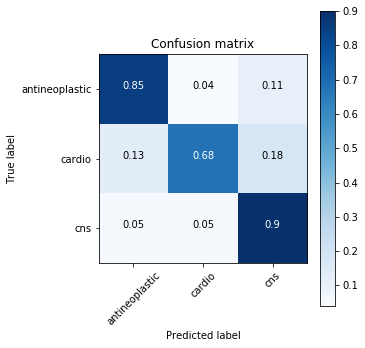

In [225]:
### plot confusion matrix showing per-class predictions
plt.rcParams['figure.figsize'] = [5, 5] ### size of the picture
log_preds,y = learn.TTA()  ### perform predictions and save the output
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)
#probs = probs[:,1]
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)


label 2
label 1
label 0


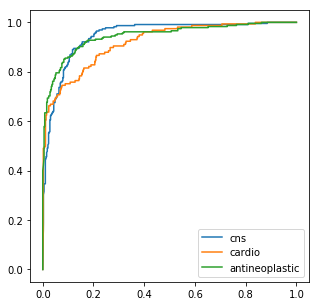

In [226]:
#y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, probs[:,2], pos_label=2)
print('label 2')
plt.plot(fpr, tpr, label = data.classes[2])

print('label 1')
fpr, tpr, thresholds = metrics.roc_curve(y, probs[:,1], pos_label=1)
plt.plot(fpr, tpr, label = data.classes[1])

print('label 0')
fpr, tpr, thresholds = metrics.roc_curve(y, probs[:,0], pos_label=0)
plt.plot(fpr, tpr, label = data.classes[0])
plt.legend()

### 5-class, 5-fold cross validation, no data augmentation, precomputed activations

In [ ]:
label_csv = f'{PATH}5cls_rmsaltol.csv'
#n = len(list(open(label_csv))) - 1
vacc =[]
reps=1   ### change to 5 for 5-fold cross validation
start=1  #### change to 0 to start at first set for 5-fold cross validation
bs=200
valididx_base = '5cls_val_ids'

for rep in range(reps):
    print(rep+start)
    val_idxs = get_val_idx_fromfile(f'{PATH}'+valididx_base+str(rep+start)+'.csv')
    data = get_data(sz, bs, val_idxs, label_csv)
    learn = ConvLearner.pretrained(arch, data, precompute=True)
    val_loss, val_acc = learn.fit(1e-2, 10, cycle_len=1, cycle_mult=2)
    vacc.append(val_acc)
print('5 class average, cyclic learning')
print(np.mean(vacc))
print(np.std(vacc))

In [ ]:
#### plot confusion matrix
plt.rcParams['figure.figsize'] = [5, 5]
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)

### 12-class, 5-fold cross validation, no data augmentation, precomputed activations

In [ ]:
label_csv = f'{PATH}12cls_rmsaltol.csv'
#n = len(list(open(label_csv))) - 1
vacc =[]
reps=1   ### change to 5 for 5-fold cross validation
start=1  #### change to 0 to start at first set for 5-fold cross validation
bs=200
valididx_base = '12cls_val_ids'

for rep in range(reps):
    print(rep+start)
    val_idxs = get_val_idx_fromfile(f'{PATH}'+valididx_base+str(rep+start)+'.csv')
    data = get_data(sz, bs, val_idxs, label_csv)
    learn = ConvLearner.pretrained(arch, data, precompute=True)
    val_loss, val_acc = learn.fit(1e-2, 10, cycle_len=1, cycle_mult=2)
    vacc.append(val_acc)
print('12 class average, cyclic learning')
print(np.mean(vacc))
print(np.std(vacc))

In [ ]:
### 12-class confusion matrix
plt.rcParams['figure.figsize'] = [10, 10]   #### make the plot size bigger than the others
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)